In [1]:
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults, ARIMAResultsWrapper
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna
from optuna import Trial

import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import os
import pathlib

import warnings


%matplotlib inline
sns.set_style(style="darkgrid")
warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

download_path = r"C:\Users\ahmed\Downloads"
download_path = pathlib.Path(download_path)

device = torch.device(device=("cuda" if torch.cuda.is_available() else "cpu"))

In [2]:
import yfinance as yf

# Download Amazon stock data from 1997 to 2024
df = yf.download("AMZN", start="1997-01-01", end="2024-12-31")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
1997-05-15,0.097917,0.125000,0.096354,0.121875,1443120000
1997-05-16,0.086458,0.098958,0.085417,0.098438,294000000
1997-05-19,0.085417,0.088542,0.081250,0.088021,122136000
1997-05-20,0.081771,0.087500,0.081771,0.086458,109344000
1997-05-21,0.071354,0.082292,0.068750,0.081771,377064000
...,...,...,...,...,...
2024-12-23,225.059998,226.880005,223.899994,225.009995,28070000
2024-12-24,229.050003,229.139999,226.130005,226.940002,15007500


In [4]:
import plotly.express as px
px.line(df["Close"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6952 entries, 1997-05-15 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AMZN)   6952 non-null   float64
 1   (High, AMZN)    6952 non-null   float64
 2   (Low, AMZN)     6952 non-null   float64
 3   (Open, AMZN)    6952 non-null   float64
 4   (Volume, AMZN)  6952 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 325.9 KB


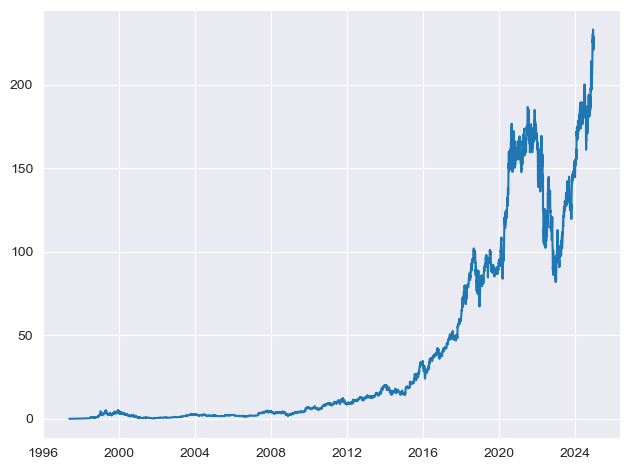

In [6]:
plt.plot(df["Close"])
plt.tight_layout()

In [12]:
from copy import deepcopy

def prepare_data_for_lstm(df: DataFrame, n_step):
    mod_df = deepcopy(df)
    
    for i in range(1, n_step + 1):
        mod_df[f"Close(t-{i})"] = mod_df["Close"].shift(i)
    
    mod_df.dropna(inplace=True)
    
    return mod_df


look_back = 7
shifted_df = prepare_data_for_lstm(df=df[["Close"]], n_step=look_back)
shifted_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Ticker,AMZN,,,,,,,
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2024-12-23,225.059998,224.919998,223.289993,220.520004,231.149994,232.929993,227.460007,228.970001
2024-12-24,229.050003,225.059998,224.919998,223.289993,220.520004,231.149994,232.929993,227.460007


In [ ]:
# normalize the data

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df)
shifted_df_as_np

array([[-0.99992842, -0.99996421, -1.        , ..., -0.9998658 ,
        -0.99985686, -0.99975844],
       [-0.99995079, -0.99992842, -0.99995527, ..., -0.99989711,
        -0.9998658 , -0.99985686],
       [-0.99996198, -0.99995079, -0.99991948, ..., -0.99998658,
        -0.99989711, -0.9998658 ],
       ...,
       [ 0.94949746,  0.96667522,  0.93240584, ...,  0.89341254,
         0.98471187,  1.        ],
       [ 0.92115412,  0.94949746,  0.96667537, ...,  0.91720355,
         0.89341254,  0.98471187],
       [ 0.90011138,  0.92115412,  0.94949768, ...,  0.9312034 ,
         0.91720355,  0.89341254]], shape=(6945, 8))

In [17]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0 ]

X = deepcopy(np.flip(X, axis=1))
X

array([[-0.99975844, -0.99985686, -0.9998658 , ..., -0.99998658,
        -1.        , -0.99996421],
       [-0.99985686, -0.9998658 , -0.99989711, ..., -1.        ,
        -0.99995527, -0.99992842],
       [-0.9998658 , -0.99989711, -0.99998658, ..., -0.99995527,
        -0.99991948, -0.99995079],
       ...,
       [ 1.        ,  0.98471187,  0.89341254, ...,  0.9312034 ,
         0.93240584,  0.96667522],
       [ 0.98471187,  0.89341254,  0.91720355, ...,  0.93240584,
         0.96667537,  0.94949746],
       [ 0.89341254,  0.91720355,  0.9312034 , ...,  0.96667537,
         0.94949768,  0.92115412]], shape=(6945, 7))

In [16]:
X

array([[-0.99996421, -1.        , -0.99998658, ..., -0.9998658 ,
        -0.99985686, -0.99975844],
       [-0.99992842, -0.99995527, -1.        , ..., -0.99989711,
        -0.9998658 , -0.99985686],
       [-0.99995079, -0.99991948, -0.99995527, ..., -0.99998658,
        -0.99989711, -0.9998658 ],
       ...,
       [ 0.96667522,  0.93240584,  0.9312034 , ...,  0.89341254,
         0.98471187,  1.        ],
       [ 0.94949746,  0.96667537,  0.93240584, ...,  0.91720355,
         0.89341254,  0.98471187],
       [ 0.92115412,  0.94949768,  0.96667537, ...,  0.9312034 ,
         0.91720355,  0.89341254]], shape=(6945, 7))

In [24]:
# preparing the data for training 
amount_data = int(len(X) * 0.8)

X_train = X[:amount_data]
X_test = X[amount_data:]

y_train = y[:amount_data]
y_test = y[amount_data:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5556, 7), (1389, 7), (5556,), (1389,))

In [116]:
# prepare datasets to tensors => (class )
from typing import Tuple

class LSTMDataSET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X: Tensor = torch.tensor(data=X, dtype=torch.float32)
        self.y: Tensor = torch.tensor(data=y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index) -> Tuple[Tensor, Tensor]:
        return self.X[index], self.y[index]

"""
Preparation for the data loader and convert trining and testing data to tensors
"""

train_data = LSTMDataSET(X=X_train, y=y_train)
test_data = LSTMDataSET(X=X_test, y=y_test)


BATCH_SIZE = 32

train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    pin_memory=True, 
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    pin_memory=True, 
    shuffle=False
)
train_data, test_data, train_loader, test_loader

(<__main__.LSTMDataSET at 0x2935eb964b0>,
 <torch.utils.data.dataloader.DataLoader at 0x2935e3a52e0>)

In [117]:
def objectives(trails: Trial):
    pass

In [118]:
tX, ty = next(iter(train_loader))
tX.size(dim=0)

32

In [143]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_stacked_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Ensure input is 3D (batch_size, seq_length, input_size)
        if x.dim() == 2:
            x = x.unsqueeze(0)  # Add batch dimension if missing
        
        batch_size = x.size(0)
        
        # Initialize hidden states with proper dimensions
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Take last timestep only
        return out.squeeze(-1)  # shape: (batch_size,)

model = LSTM(7, 4, 5)
model



LSTM(
  (lstm): LSTM(7, 4, num_layers=5, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [120]:
from torchmetrics import Metric, R2Score, MeanAbsoluteError, MeanSquaredError


def evaluation_metrics(predictions, actual):
    # Ensure predictions and actual are same shape
    predictions = predictions.squeeze(-1) if predictions.dim() > 1 else predictions
    actual = actual.squeeze(-1) if actual.dim() > 1 else actual
    
    r2 = R2Score().to(device)
    mae = MeanAbsoluteError().to(device)
    mse = MeanSquaredError().to(device)
    
    r2.update(predictions, actual)
    mae.update(predictions, actual)
    mse.update(predictions, actual)
    
    return r2.compute(), mae.compute(), mse.compute()

def training_step(model:nn.Module, train_loader: DataLoader, loss_fn: nn.Module, optimizer: optim.Optimizer, device: torch.device): 
    model.train()
    
    model.train()
    for batch, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        # Forward pass
        predictions = model(X_train)
    
        
        # Calculate loss
        loss = loss_fn(predictions, y_train)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        if batch % 50 == 0:
            # r2, mae, mse = evaluation_metrics(predictions, y_train, device)
            # | R2: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f}
            print(f"Batch {batch:3d} | Loss: {loss.item():.4f} ")


def eval_step(model: nn.Module, test_loader: DataLoader, loss_fn: nn.Module, device: torch.device): 
    model.eval()
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test= X_test.to(device), y_test.to(device)

            predictions  = model(X_test)
            
            
            loss = loss_fn(predictions , y_test)
            
            # r2_score, mae_score, mse_score = evaluation_metrics(predictions=predictions, actual=y_train).to(device)
            # | r2: {r2_score.item():.4f} | MAE: {mae_score.item():.4f} | mse: {mse_score.item():.4f}
            if batch % 50 == 0:
                print(f"[TESTING] Batch: {batch} | loss: {loss.item():.4f}")
            

def training_loop(
    model:nn.Module, epochs: int, train_loader: DataLoader,test_loader: DataLoader, 
    loss_fn: nn.Module, optimizer: optim.Optimizer, device: torch.device
    ): 
    
    for epoch in tqdm(range(epochs), desc="Training and eval time series analysis".title()):
        print(f"[EPOCH] {epoch}/{epochs}")
        training_step(model=model, train_loader=train_loader,loss_fn=loss_fn, optimizer=optimizer, device=device)
        eval_step(model=model,test_loader=test_loader, loss_fn=loss_fn, device=device)

In [121]:
LEARNING_RATE = 1e-4
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.L1Loss()

EPOCHS = 20

training_loop(model=model, epochs=EPOCHS, train_loader=train_loader, test_loader=test_loader, loss_fn=loss_fn, optimizer=optimizer, device=device)

Training And Eval Time Series Analysis:   0%|          | 0/20 [00:00<?, ?it/s]

[EPOCH] 0/20
Batch   0 | Loss: 0.5969 
Batch  50 | Loss: 0.5398 
Batch 100 | Loss: 0.4720 
Batch 150 | Loss: 0.1689 
[TESTING] Batch: 0 | loss: 0.3497
[EPOCH] 1/20
Batch   0 | Loss: 0.4745 
Batch  50 | Loss: 0.4175 
Batch 100 | Loss: 0.3357 
Batch 150 | Loss: 0.0140 
[TESTING] Batch: 0 | loss: 0.4870
[EPOCH] 2/20
Batch   0 | Loss: 0.3343 
Batch  50 | Loss: 0.2663 
Batch 100 | Loss: 0.1592 
Batch 150 | Loss: 0.1679 
[TESTING] Batch: 0 | loss: 0.6377
[EPOCH] 3/20
Batch   0 | Loss: 0.1800 
Batch  50 | Loss: 0.1043 
Batch 100 | Loss: 0.0099 
Batch 150 | Loss: 0.2116 
[TESTING] Batch: 0 | loss: 0.6760
[EPOCH] 4/20
Batch   0 | Loss: 0.1398 
Batch  50 | Loss: 0.0693 
Batch 100 | Loss: 0.0289 
Batch 150 | Loss: 0.2280 
[TESTING] Batch: 0 | loss: 0.6933
[EPOCH] 5/20
Batch   0 | Loss: 0.1211 
Batch  50 | Loss: 0.0529 
Batch 100 | Loss: 0.0236 
Batch 150 | Loss: 0.2217 
[TESTING] Batch: 0 | loss: 0.6866
[EPOCH] 6/20
Batch   0 | Loss: 0.1259 
Batch  50 | Loss: 0.0591 
Batch 100 | Loss: 0.0280 
Bat

X_train shape torch.Size([5556, 7])
X_train unsqueeze shape  torch.Size([1, 5556, 7])
model prediction: tensor([0.2343])


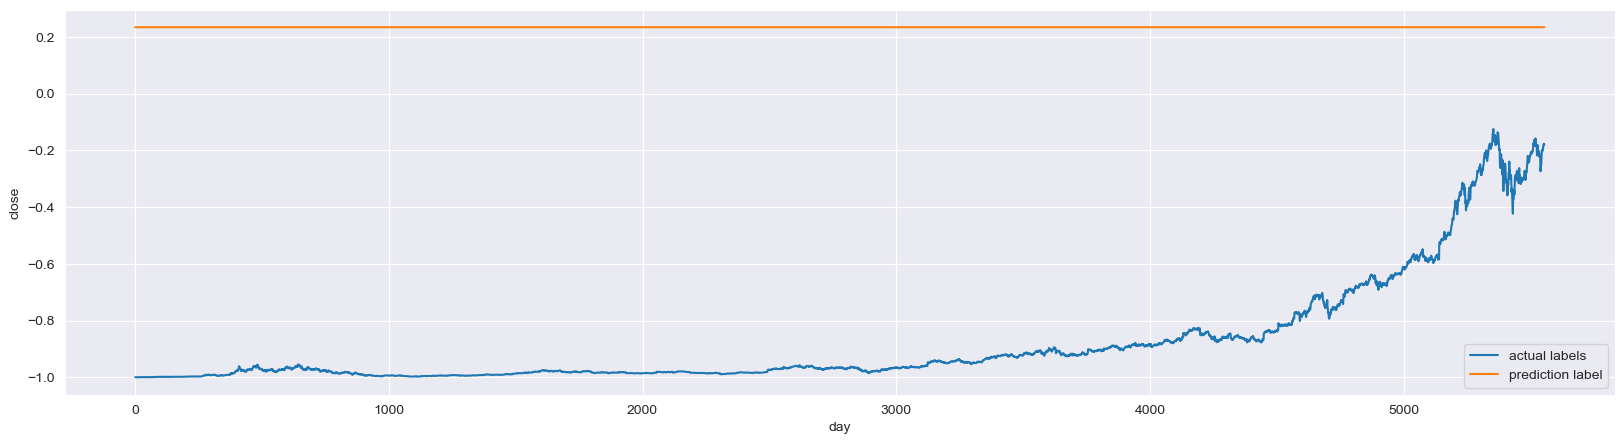

In [147]:
with torch.inference_mode():
    predictions = []
    
    t = torch.tensor(X_train, dtype=torch.float32, device=device)
    
    t_sq = t.unsqueeze(dim=0)
    for i in t:
        i = i.unsqueeze(0)
        prediction = model(i)
        predictions.append(prediction.item())
    print("X_train shape", t.shape) 
    print("X_train unsqueeze shape ", t_sq.shape) 
    print("model prediction:", prediction)


plt.figure(figsize=(20,5))
plt.plot(y_train, label="actual labels")
plt.plot(predictions, label = "prediction label")
plt.xlabel("day")
plt.ylabel("close")
plt.legend()
plt.show()



In [148]:
model.eval()
with torch.inference_mode():
    prediction = model(t)
prediction

tensor([0.2653])

In [46]:
ii.shape

torch.Size([32])

In [47]:
len(test_loader)

218